In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
%matplotlib inline

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
#import io
 
#data = pd.read_csv(io.BytesIO(uploaded['df_limpio_v2.csv']))
#data.head()

In [2]:
#get data
path = input('path to the csv: ')
data = pd.read_csv(f"{path}")
data.head()

#/Users/danielriojas/Documents/Random_2022/df_limpio_v1.csv
#/Users/danielriojas/Downloads/twitter_reddit_clean.csv 

path to the csv: /Users/danielriojas/Downloads/twitter_reddit_clean.csv


,Unnamed: 0,text,label
0,0,god morning stil excited schol people,0
1,1,never felt low life wish easy way kil like fal...,1
2,2,haha love hate relationship yelow great doesnt...,0
3,3,day legendary season finale quot met mother quot,0
4,4,completely oposite girl say swet stuf thought ...,1


In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25368 entries, 0 to 25367
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25284 non-null  object
 1   label   25368 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 396.5+ KB


In [5]:
data = data.dropna()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25284 entries, 0 to 25367
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25284 non-null  object
 1   label   25284 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 592.6+ KB


In [7]:
positive_data = data[data.label == 0]
positive_data.shape

(12605, 2)

In [8]:
depression_data = data[data.label==1]
depression_data.shape

(12679, 2)

In [9]:
text_col = input('data: ')
X = data[f'{text_col}']

target_col = input('target: ')
y = data[f'{target_col}']

data: text
target: label


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [11]:
nltk.download('punkt')

X_train = [nltk.tokenize.word_tokenize(str(_)) for _ in X_train]
X_test = [nltk.tokenize.word_tokenize(str(_)) for _ in X_test]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielriojas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
from gensim.models import Word2Vec

In [15]:
#embedding
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)

In [16]:
#cortamos maxlen en 400 
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 400,truncating= 'post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 400 , truncating = 'post')

In [17]:
# Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Conv1D, Flatten, Dense

def init_model():
    model = Sequential()
    model.add(Masking())
    
    model.add(Conv1D(10, kernel_size=3))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','Recall'])
    
    return model

model = init_model()

2022-03-10 12:42:42.350782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose = 1
         )

Epoch 1/100
388/388 [==============================] - 16s 38ms/step - loss: 0.1520 - accuracy: 0.9396 - recall: 0.9104 - val_loss: 0.0966 - val_accuracy: 0.9672 - val_recall: 0.9599
Epoch 2/100
388/388 [==============================] - 11s 28ms/step - loss: 0.0884 - accuracy: 0.9682 - recall: 0.9564 - val_loss: 0.0886 - val_accuracy: 0.9689 - val_recall: 0.9526
Epoch 3/100
388/388 [==============================] - 8s 20ms/step - loss: 0.0825 - accuracy: 0.9701 - recall: 0.9580 - val_loss: 0.0851 - val_accuracy: 0.9704 - val_recall: 0.9606
Epoch 4/100
388/388 [==============================] - 7s 18ms/step - loss: 0.0787 - accuracy: 0.9716 - recall: 0.9606 - val_loss: 0.0826 - val_accuracy: 0.9719 - val_recall: 0.9592
Epoch 5/100
388/388 [==============================] - 7s 19ms/step - loss: 0.0787 - accuracy: 0.9726 - recall: 0.9637 - val_loss: 0.0892 - val_accuracy: 0.9702 - val_recall: 0.9728
Epoch 6/100
388/388 [==============================] - 11s 29ms/step - loss: 0.0756 - ac

In [19]:
result = model.evaluate(X_test_pad, y_test, verbose = 1, return_dict=True)
result

238/238 [==============================] - 5s 19ms/step - loss: 0.0696 - accuracy: 0.9768 - recall: 0.9700


{'loss': 0.06959795951843262,
 'accuracy': 0.9767993688583374,
 'recall': 0.9700208306312561}

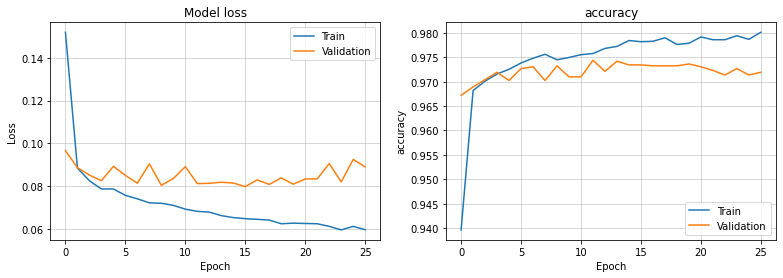

In [20]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

plot_loss(history_fit)